In [17]:
# Import necessary libraries
import pandas as pd
from ast import literal_eval
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import warnings
import ast
import seaborn as sns
import itertools
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, roc_auc_score
from scipy.stats import anderson_ksamp, kruskal, ks_2samp



In [18]:
test = pd.read_pickle('../../data/embeddings_chexpert/CNNs/chexpert_on_chexpert_test_with_embeddings_extracted.pkl')
train = pd.read_pickle('../../data/embeddings_chexpert/CNNs/chexpert_on_chexpert_train_with_embeddings_extracted.pkl')
valid = pd.read_pickle('../../data/embeddings_chexpert/CNNs/chexpert_on_chexpert_valid_with_embeddings_extracted.pkl')
test.columns

Index(['gender', 'race', 'age', 'insurance', 'Atelectasis', 'Cardiomegaly',
       'Consolidation', 'Edema', 'Enlarged Cardiomediastinum', 'Fracture',
       'Lung Lesion', 'Lung Opacity', 'No Finding', 'Pleural Effusion',
       'Pleural Other', 'Pneumonia', 'Pneumothorax', 'Support Devices',
       'embeddings'],
      dtype='object')

In [19]:
col = ['gender', 'race', 'age', 'Atelectasis',
       'Cardiomegaly', 'Consolidation', 'Edema', 'Enlarged Cardiomediastinum',
       'Fracture', 'Lung Lesion', 'Lung Opacity', 'No Finding',
       'Pleural Effusion', 'Pleural Other', 'Pneumonia', 'Pneumothorax',
       'Support Devices', 'embeddings']
test = test[col]
train = train[col]
valid = valid[col]


In [20]:
col = ['sex', 'race', 'age', 'Atelectasis',
       'Cardiomegaly', 'Consolidation', 'Edema', 'Enlarged Cardiomediastinum',
       'Fracture', 'Lung Lesion', 'Lung Opacity', 'No Finding',
       'Pleural Effusion', 'Pleural Other', 'Pneumonia', 'Pneumothorax',
       'Support Devices', 'embeddings']
test.columns = col
train.columns = col
valid.columns = col

In [21]:
initial_size = test.shape[0] 
test = test[test['embeddings'].apply(type) == list]
final_size = test.shape[0] 
print(f'Number of test removed rows = {initial_size - final_size}')

initial_size = train.shape[0] 
train = train[train['embeddings'].apply(type) == list]
final_size = train.shape[0] 
print(f'Number of train removed rows = {initial_size - final_size}')

initial_size = valid.shape[0]
valid = valid[valid['embeddings'].apply(type) == list]
final_size = valid.shape[0]
print(f'Number of valid removed rows = {initial_size - final_size}')

Number of test removed rows = 51
Number of train removed rows = 67
Number of valid removed rows = 3


## Visualize embeddings using PCA and t-SNE plots

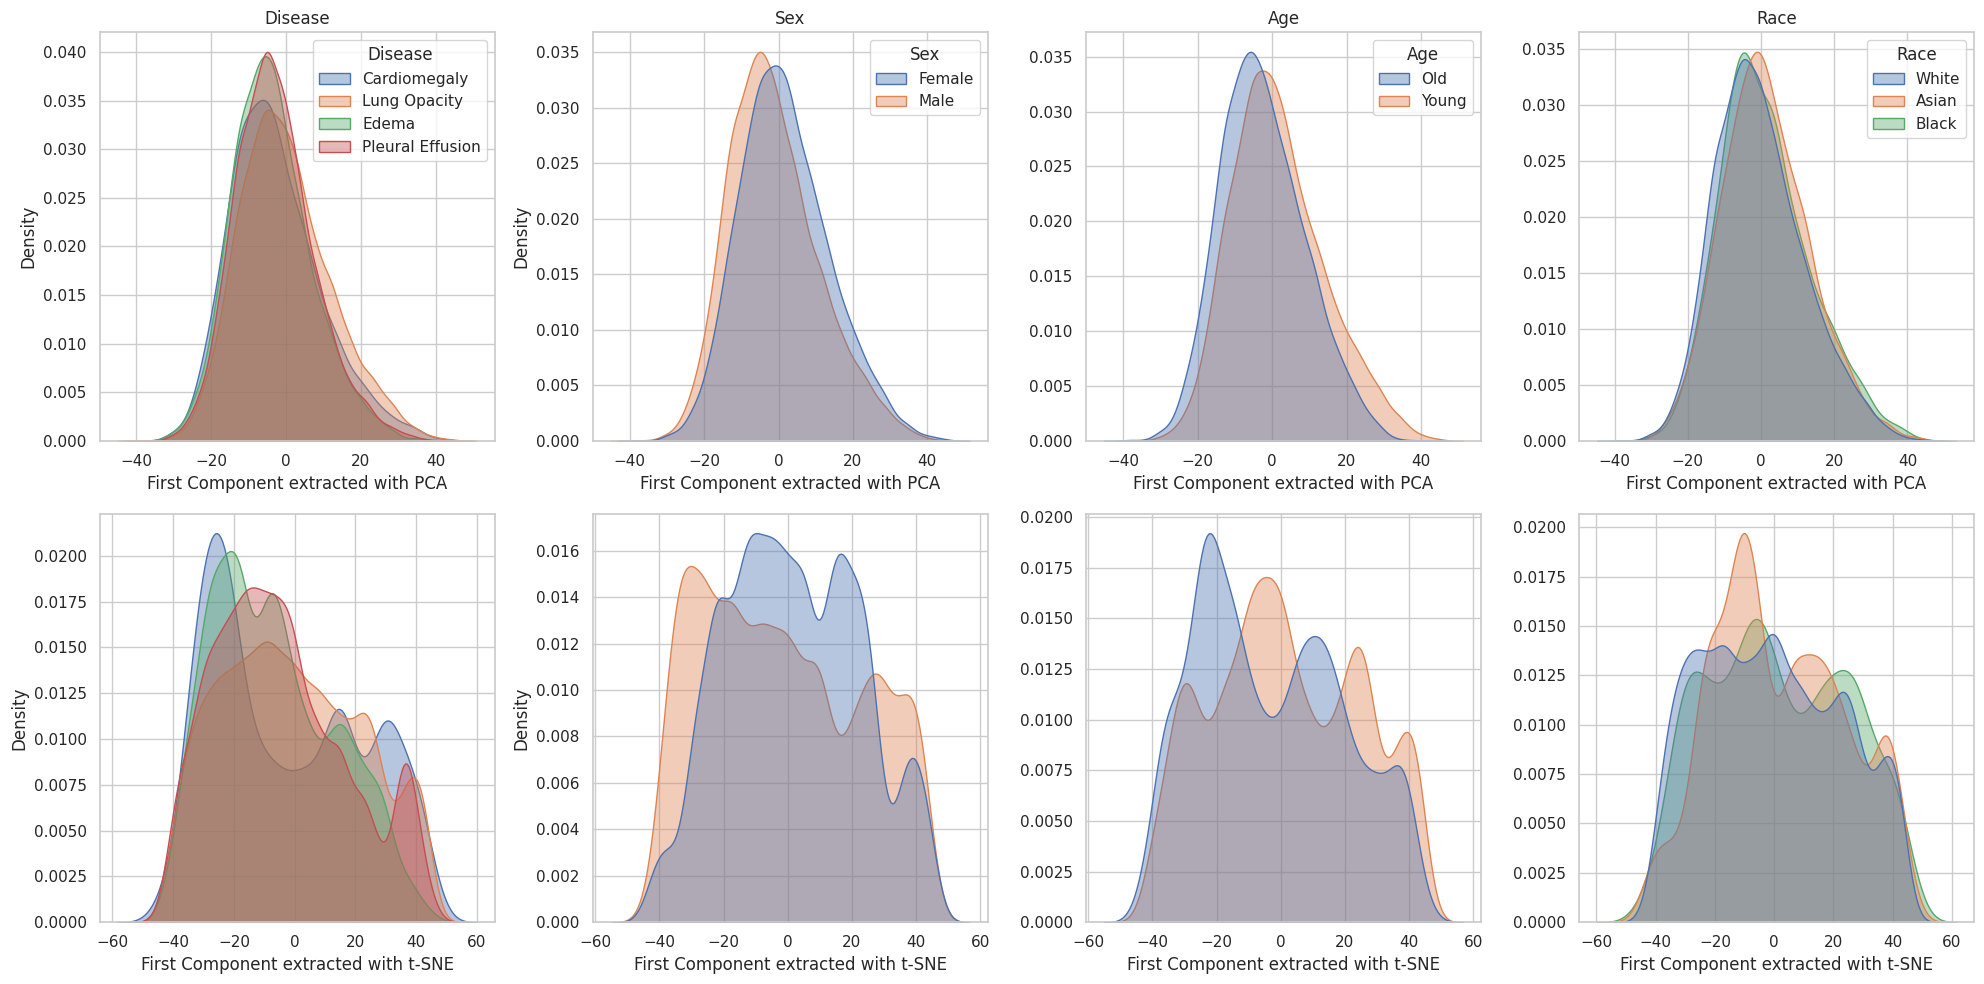

In [ ]:
diseases_of_interest = ['Cardiomegaly', 'Lung Opacity', 'Edema', 'Pleural Effusion']
df = test[test[diseases_of_interest].any(axis=1)].copy()

# extract and normalize embeddings ---
emb = np.stack(df['embeddings'].values)
emb_norm = StandardScaler().fit_transform(emb)

# PCA → 1D & t-SNE → 1D
df['PCA_1']  = PCA(n_components=1).fit_transform(emb_norm)[:, 0]
df['TSNE_1'] = TSNE(n_components=1, random_state=42, init='pca').fit_transform(emb_norm)[:, 0]

# integer codes back to labels 
sex_map  = {0: 'Male', 1: 'Female'}
race_map = {0: 'White', 1: 'Asian', 2: 'Black'}
age_map  = {0: 'Young', 1: 'Old'} 

df['Sex']  = df['sex'].map(sex_map)
df['Race'] = df['race'].map(race_map)
df['Age']  = df['age'].map(age_map)


sns.set(style="whitegrid")
fig, axes = plt.subplots(2, 4, figsize=(20, 10), sharey=False)

# Plot diseases of interest
# PCA row
ax = axes[0, 0]
for dis in diseases_of_interest:
    subset = df[df[dis] == 1]
    sns.kdeplot(
        data=subset, x='PCA_1',
        label=dis,
        common_norm=False, fill=True, alpha=0.4,
        ax=ax
    )
ax.set_title("Disease")
ax.set_xlabel("First Component extracted with PCA")
ax.set_ylabel("Density")
ax.legend(title="Disease", loc='upper right')

# t-SNE row
ax = axes[1, 0]
for dis in diseases_of_interest:
    subset = df[df[dis] == 1]
    sns.kdeplot(
        data=subset, x='TSNE_1',
        label=dis,
        common_norm=False, fill=True, alpha=0.4,
        ax=ax
    )
ax.set_xlabel("First Component extracted with t-SNE")
ax.set_ylabel("Density")


groupings = [
    ('Sex',  'Sex'),
    ('Age',  'Age'),
    ('Race', 'Race'),
]

# Sex Age Race
for col_idx, (title, lbl_col) in enumerate(groupings, start=1):
    # PCA row
    ax = axes[0, col_idx]
    sns.kdeplot(
        data=df, x='PCA_1', hue=lbl_col,
        common_norm=False, fill=True, alpha=0.4,
        ax=ax
    )
    ax.set_title(title)
    ax.set_xlabel("First Component extracted with PCA")
    if col_idx == 1:
        ax.set_ylabel("Density")
    else:
        ax.set_ylabel("")

    # t-SNE row
    ax = axes[1, col_idx]
    sns.kdeplot(
        data=df, x='TSNE_1', hue=lbl_col,
        common_norm=False, fill=True, alpha=0.4,
        ax=ax
    )
    ax.set_xlabel("First Component extracted with t-SNE")
    if col_idx == 1:
        ax.set_ylabel("Density")
    else:
        ax.set_ylabel("")
    ax.legend_.remove()

plt.tight_layout()
plt.show()


# Predict subgroups from embeddings

In [23]:
# Extract embedding arrays and standardize
def prepare_X(df):
    X = np.stack(df['embeddings'].values)
    return X

X_train = prepare_X(train)
X_valid = prepare_X(valid)
X_test  = prepare_X(test)

scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled  = scaler.transform(X_test)

In [24]:
y_train = train['sex'].values
y_valid = valid['sex'].values
y_test  = test['sex'].values


clf = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

clf.fit(X_train_scaled, y_train)
y_pred_test = clf.predict(X_test_scaled)
y_proba_test = clf.predict_proba(X_test_scaled)[:, 1]

acc_test = accuracy_score(y_test, y_pred_test)
auc_test = roc_auc_score(y_test, y_proba_test)

print(f"Sex Test Accuracy: {acc_test:.4f}")
print(f"Sex Test AUC:      {auc_test:.4f}")

Sex Test Accuracy: 0.7870
Sex Test AUC:      0.8681


In [25]:
y_train = train['age'].values
y_valid = valid['age'].values
y_test  = test['age'].values


clf = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

clf.fit(X_train_scaled, y_train)
y_pred_test = clf.predict(X_test_scaled)
y_proba_test = clf.predict_proba(X_test_scaled)[:, 1]

acc_test = accuracy_score(y_test, y_pred_test)
auc_test = roc_auc_score(y_test, y_proba_test)

print(f"Age Test Accuracy: {acc_test:.4f}")
print(f"Age Test AUC:      {auc_test:.4f}")

Age Test Accuracy: 0.7220
Age Test AUC:      0.7745


In [26]:
y_train = train['race'].values
y_valid = valid['race'].values
y_test  = test['race'].values

clf = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)


clf.fit(X_train_scaled, y_train)


y_pred_test  = clf.predict(X_test_scaled)
y_proba_test = clf.predict_proba(X_test_scaled)
acc_test = accuracy_score(y_test, y_pred_test)

# multiclass AUC: specify multi_class and average
#    - multi_class='ovr' does one-vs-rest
#    - average='macro' unweights each class equally
auc_test = roc_auc_score(
    y_test,
    y_proba_test,
    multi_class='ovr',
    average='macro'
)

print(f"Race Test Accuracy: {acc_test:.4f}")
print(f"Race Test AUC (OvR, macro‐avg): {auc_test:.4f}")


Race Test Accuracy: 0.7829
Race Test AUC (OvR, macro‐avg): 0.6843


#  Statistical tests

In [27]:
embeddings = np.array(test['embeddings'].tolist())
scaler = StandardScaler()
embeddings_normalized = scaler.fit_transform(embeddings)

pca = PCA(n_components=2)
pca_result = pca.fit_transform(embeddings_normalized)

df = test.copy()
for i in range(2):
    df[f'PCA_{i+1}'] = pca_result[:, i]


In [28]:
group_male = df[df['sex'] == 0]
group_female = df[df['sex'] == 1]

pca_columns = ['PCA_1', 'PCA_2']
ks_results = {}

# Run Kolmogorov-Smirnov test for each PCA column
for column in pca_columns:
    ks_stat, p_value = ks_2samp(group_male[column], group_female[column])
    ks_results[column] = {'KS Statistic': ks_stat, 'p-value': p_value}
print("Kolmogorov-Smirnov test results for sex:")
ks_results


Kolmogorov-Smirnov test results for sex:


{'PCA_1': {'KS Statistic': 0.08771435727821902,
  'p-value': 3.6291723116657447e-66},
 'PCA_2': {'KS Statistic': 0.08759006054344287,
  'p-value': 5.575424624255712e-66}}

In [29]:
group_young = df[df['age'] == 0]
group_old = df[df['age'] == 1]

pca_columns = ['PCA_1', 'PCA_2']
ks_results = {}

# Run Kolmogorov-Smirnov test for each PCA column
for column in pca_columns:
    ks_stat, p_value = ks_2samp(group_young[column], group_old[column])
    ks_results[column] = {'KS Statistic': ks_stat, 'p-value': p_value}
print("Kolmogorov-Smirnov test results for age:")
ks_results


Kolmogorov-Smirnov test results for age:


{'PCA_1': {'KS Statistic': 0.1575867734089521,
  'p-value': 1.482316284267427e-204},
 'PCA_2': {'KS Statistic': 0.05507858801145632,
  'p-value': 2.993913738975871e-25}}

In [30]:
race_categories = test['race'].unique()

ks_results_race = {}

for column in pca_columns:
    ks_results_race[column] = {}

    for race_pair in itertools.combinations(race_categories, 2):
        race_1, race_2 = race_pair

        group_race_1 = df[df['race'] == race_1]
        group_race_2 = df[df['race'] == race_2]
        ks_stat, p_value = ks_2samp(group_race_1[column], group_race_2[column])
        ks_results_race[column][column,f"{race_1} vs {race_2}"] = {'KS Statistic': ks_stat, 'p-value': p_value}

print("Kolmogorov-Smirnov test results for race:")
ks_results_race

Kolmogorov-Smirnov test results for race:


{'PCA_1': {('PCA_1', '0 vs 1'): {'KS Statistic': 0.062406811251903116,
   'p-value': 2.816746887925288e-17},
  ('PCA_1', '0 vs 2'): {'KS Statistic': 0.048394028347692075,
   'p-value': 8.286924188928021e-06},
  ('PCA_1', '1 vs 2'): {'KS Statistic': 0.023592068532746344,
   'p-value': 0.22703146592494697}},
 'PCA_2': {('PCA_2', '0 vs 1'): {'KS Statistic': 0.17683916416107454,
   'p-value': 1.772274370076926e-136},
  ('PCA_2', '0 vs 2'): {'KS Statistic': 0.04253901271451037,
   'p-value': 0.00013837490741014472},
  ('PCA_2', '1 vs 2'): {'KS Statistic': 0.20799068558695555,
   'p-value': 9.174975955746915e-74}}}